### Fetch HydroViz data from Geoserver / Rasdaman*

This notebook demonstrates how to fetch the SECASC HydroViz vector data (stream segments and watersheds) from Geoserver using a HUC6 polygon. 

The geometry attributes are then used to query streamflow statistics data from Rasdaman (*coming soon!)

In [61]:
import requests
import geopandas as gpd
from matplotlib import pyplot as plt

# set parameters using dev version of Geoserver
base_url = 'https://gs.earthmaps.io/geoserver/'
dir = 'hydrology'
layers = ['seg', 'hru']
output = 'application/json'
wfs_get_string = '/ows?service=WFS&version=1.0.0&request=GetFeature&typeName='

# load HUC6 polygons and transform to match project CRS: EPSG:5070 (NAD83 / Conus Albers)
# in this future, this data could also be hosted on Geoserver and accessed via WFS
huc6 = gpd.read_file('/import/beegfs/CMIP6/jdpaul3/hydroviz_data/export/WBDHU6.shp').to_crs('EPSG:5070')

In [62]:
# we will build a function that uses a single polygon to define the bounding box request

def get_bbox_features_and_clip(base_request_string, polygon_gdf):
    # get the bounds of the polygon - expects a gdf with single polygon, return error if not
    if len(polygon_gdf) > 1:
        print('Input polygon gdf has more than one polygon. Please provide a gdf with only one polygon.')
        return None # in the API, return a specific error
    else:
        xmin, ymin, xmax, ymax = polygon_gdf.bounds.values[0]

        # build the bbox string, double checking that the xmin/xmax values are in the correct order
        # this is somewhat redundant but when the projected coordinates are negative, the order can be flipped and produce errors
        bbox_string = str(int(min(xmin, xmax))) + ", " + str(int(min(ymin, ymax))) + ", " + str(int(max(xmin, xmax))) + ", " + str(int(max(ymin, ymax)))
        
        # create the bbox request string
        bbox_request_string = base_request_string + "&bbox=" + bbox_string

        # also tried this with a CQL filter..."the_geom" is the default geometry field in Geoserver
        #cql_bbox_request_string = base_request_string + "&cql_filter=bbox(the_geom," + bbox_string + ")"

        print(f"Fetching data for {polygon_gdf.name.loc[0]} (HUC6: {polygon_gdf.huc6.loc[0]}) using bbox: {bbox_string}")

        # get the features
        with requests.get(bbox_request_string, verify=False) as r: # verify=False is necessary for dev version of Geoserver
            if r.status_code != 200:
                print('Failed to get features!')
                return None # in the API, return a specific error
            else:
                try: 
                    r_json = r.json()

                    # clip the features to the polygon
                    bbox_gdf = gpd.GeoDataFrame.from_features(r_json['features'], crs='EPSG:5070')
                    
                    clipped_gdf = gpd.clip(bbox_gdf, polygon_gdf)
                    
                    return clipped_gdf
                except:
                    print("Unable to decode as JSON. Returning raw text:\n", r.text)
                    return r.text


<Axes: >

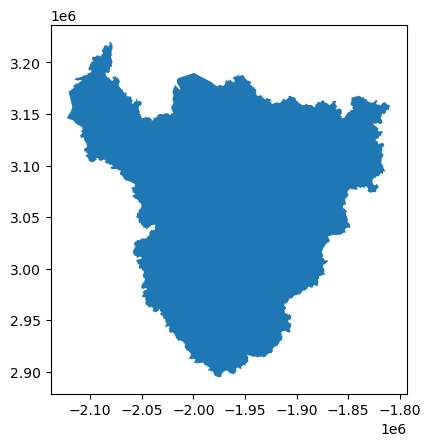

In [63]:
# let's test by using the HUC6 for Puget Sound
puget_huc6 = huc6[huc6['name']=='Puget Sound'][['name', 'huc6', 'geometry']].reset_index(drop=True)
puget_huc6.plot()

In [64]:
# and build basic feature request strings for the two geometries
# these would get all the features, but that request would definitely fail due to the size of the file!

request_strings = [base_url + dir + wfs_get_string + dir + ":" + layers[0] + "&outputFormat=" + output,
                     base_url + dir + wfs_get_string + dir + ":" + layers[1] + "&outputFormat=" + output]

print(request_strings[0])
print(request_strings[1])

https://gs.earthmaps.io/geoserver/hydrology/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=hydrology:seg&outputFormat=application/json
https://gs.earthmaps.io/geoserver/hydrology/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=hydrology:hru&outputFormat=application/json


In [65]:
# get the features
puget_segments = get_bbox_features_and_clip(request_strings[0], puget_huc6)
puget_watersheds = get_bbox_features_and_clip(request_strings[1], puget_huc6)

Fetching data for Puget Sound (HUC6: 171100) using bbox: -2122635, 2894750, -1809114, 3220385


/home/jdpaul3/miniconda3/envs/snap-geo/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gs.earthmaps.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Fetching data for Puget Sound (HUC6: 171100) using bbox: -2122635, 2894750, -1809114, 3220385


/home/jdpaul3/miniconda3/envs/snap-geo/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gs.earthmaps.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Unable to decode as JSON. Returning raw text:
 <?xml version="1.0" ?>
<ServiceExceptionReport
   version="1.2.0"
   xmlns="http://www.opengis.net/ogc"
   xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
   xsi:schemaLocation="http://www.opengis.net/ogc http://schemas.opengis.net/wfs/1.0.0/OGC-exception.xsd">
   <ServiceException>
      java.lang.IllegalArgumentException
</ServiceException></ServiceExceptionReport>


<Axes: >

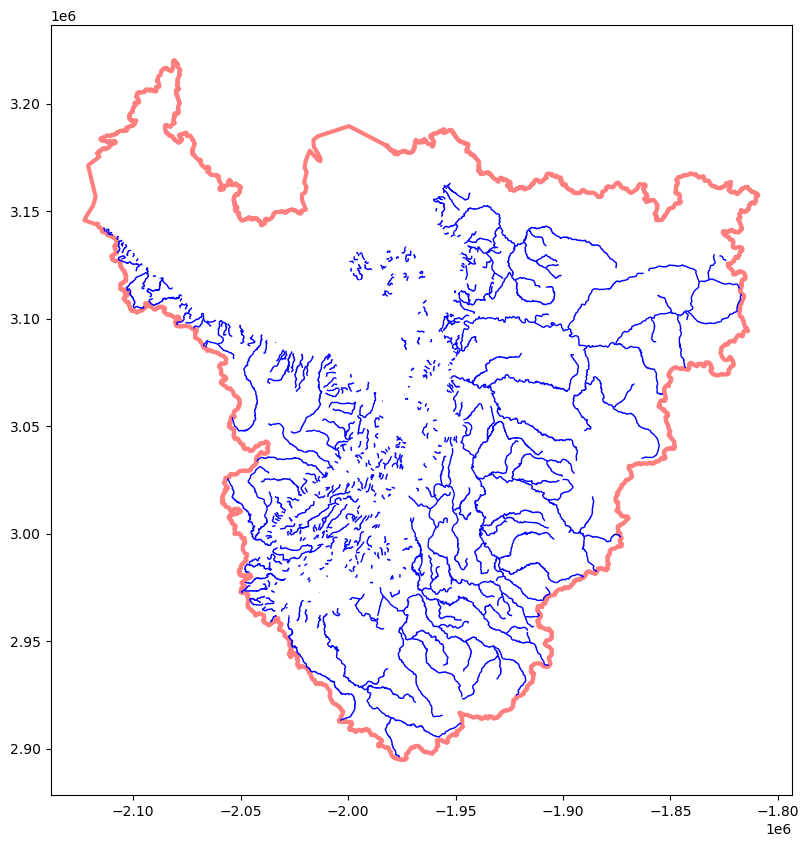

In [66]:
# plot the features enclosed within the HUC6 polygon

fig, ax = plt.subplots(figsize=(10,10))

puget_segments.plot(ax=ax, color='blue', linewidth = 1, zorder=2)
#puget_watersheds.plot(ax=ax, facecolor='gray', edgecolor="black" linewidth = 0.5, alpha=0.5, zorder=1)
puget_huc6.plot(ax=ax, facecolor='none', edgecolor='red', linewidth = 3, alpha=0.5, zorder=0)

In [67]:
# we can then use these IDs to query the stream flow data from the datacube on rasdaman
puget_segments.seg_id_nat
#puget_watersheds.hru_id_nat

732     51650
730     51648
563     51481
725     51643
727     51645
        ...  
1309    53374
1266    53331
1272    53337
1268    53333
1310    53375
Name: seg_id_nat, Length: 945, dtype: int64

In [ ]:
# here is what what an API response could look like
# a list of regions, each with a HUC6 name, HUC6 ID, a dictionary of watershed and segment data, and a feature collection of watershed and segment geometries
[{"name": "Puget Sound",
     "huc6": "171100",
     "data": {
            "watershed_data": {
                {"hru_id": "12345",
                    "landcover": {
                        "model": {
                            "scenario": {
                                "era": {
                                    "stat": {
                                        # hydroviz data goes here
                                        "fl1": 30.5,
                                        "ma1": 10.5,
                                        "dh8": 5.5,
                                    },
                                },
                            },
                        },
                    },
                },
            },
            "segment_data": {
                {"seg_id": "67890",
                    "landcover": {
                        "model": {
                            "scenario": {
                                "era": {
                                    "stat": {
                                        # hydroviz data goes here
                                        "fl1": 20.5,
                                        "ma1": 14.9,
                                        "dh8": 7.5,
                                    },
                                },
                            },
                        },
                    },
                },
            },
     "features": {
        "watershed_geometry": {
            {'type': 'FeatureCollection',
            'features': [{'type': 'Feature',
            'id': 'nhm_hru.1',
            'geometry': {'type': 'MultiPolygon',
                'coordinates': # not real coords, just an example
                [[[[492540.3905134, 1190004.05424627],
                [492560.23562589, 1189986.95983551],
                [492551.38172032, 1189975.93152857],
                [492531.52110782, 1189964.75452153],
                [492475.35017245, 1189955.8136159],
                [492448.06475528, 1189957.99011727],
                [492435.11644712, 1189966.72362277],
                [492433.53204613, 1189981.7014322],
                [492456.93416086, 1189997.28974202],
                [492512.32519573, 1190004.12924632],
                [492540.3905134, 1190004.05424627]]]]},
            'geometry_name': 'the_geom',
            'properties': {'hru_id': '12345'}},
                ],
            'totalFeatures': 1,
            'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::5070'}}},
        },
        "segment_geometry": {
            {'type': 'FeatureCollection',
            'features': [{'type': 'Feature',
            'id': 'nhm_seg.1',
            'geometry': {'type': 'MultiLineString',
                'coordinates': # not real coords, just an example
                [[[492540.3905134, 1190004.05424627],
                [492560.23562589, 1189986.95983551],
                [492551.38172032, 1189975.93152857],
                [492531.52110782, 1189964.75452153],
                [492475.35017245, 1189955.8136159],
                [492448.06475528, 1189957.99011727],
                [492435.11644712, 1189966.72362277],
                [492433.53204613, 1189981.7014322],
                [492456.93416086, 1189997.28974202],
                [492512.32519573, 1190004.12924632],
                [492540.3905134, 1190004.05424627]]]},
            'geometry_name': 'the_geom',
            'properties': {'seg_id': '67890'}},
                ],
            'totalFeatures': 1,
            'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::5070'}}},
        },
    },
},
},
# possible to have more regions as additional list items
]